In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import classification_report

In [5]:
# Directories for training and testing images
TRAINING = "dataset_at&t/Training"
TESTING = "dataset_at&t/Testing"

########################################
# 1. LOAD IMAGES INTO DICTIONARIES
########################################

# For training images:
train_images = {}  
for folder in os.listdir(TRAINING):
    folder_path = os.path.join(TRAINING, folder)
    if os.path.isdir(folder_path):
        train_images[folder] = []
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            img = Image.open(img_path)
            train_images[folder].append(np.array(img))

# For testing images:
test_images = {}
for folder in os.listdir(TESTING):
    folder_path = os.path.join(TESTING, folder)
    if os.path.isdir(folder_path):
        test_images[folder] = []
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            img = Image.open(img_path)
            test_images[folder].append(np.array(img))

In [ ]:
########################################
# Convert the training dictionary into flat lists
########################################

images = [] 
labels = [] 
for folder, img_list in train_images.items():
    for im in img_list:
        images.append(im)
        labels.append(int(folder.replace("s", "")))

shape = images[0].shape

# Mean face
X = np.resize(images, (len(images), shape[0]*shape[1]))
mean = np.mean(X, axis=0)
X_std = X - mean

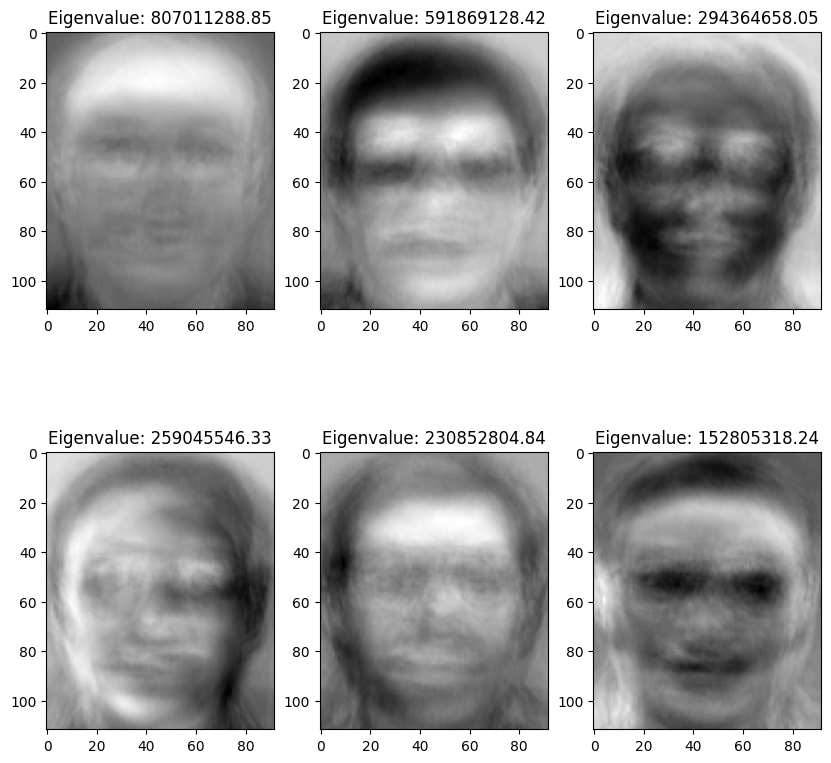

In [ ]:
# -------------------------------
# Eigendecomposition (PCA)
# -------------------------------

# covariance matrix
cov_mat = X_std @ X_std.T

# Eigendecomposition and sort eigenvectors by decreasing eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Convert eigenvectors to the actual high-dimensional space
eigenvector_converted = X_std.T @ eigenvectors

# Normalize to obtain eigenfaces
eigenfaces = eigenvector_converted.T / np.sqrt((eigenvector_converted.T ** 2).sum(axis=1, keepdims=True))

_, axs = plt.subplots(2, 3, figsize=(10, 10))
axs = axs.flatten()
for i, (face, ax) in enumerate(zip(eigenfaces, axs)):
    ax.set_title(f"Eigenvalue: {np.round(eigenvalues[i], 2)}")
    ax.imshow(face.reshape(shape[0], shape[1]), cmap="gray")
plt.show()

Number of dimensions for 85% and 95% variance: [59, 147]


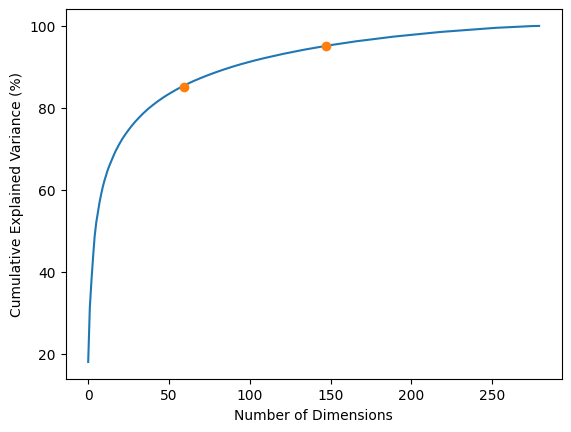

In [8]:
# -------------------------------
# Explained Variance in PCA
# -------------------------------
total = sum(eigenvalues)
explained_variance = [(val / total) * 100 for val in eigenvalues]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)

# Find dimensions to reach 85% and 95% explained variance
dims = []
for dim in range(280):
    if cum_explained_variance[dim] >= 85:
        dims.append(dim+1)
        break
for dim in range(dims[0]+1, 280):
    if cum_explained_variance[dim] >= 95:
        dims.append(dim+1)
        break
print("Number of dimensions for 85% and 95% variance:", dims)

plt.plot(cum_explained_variance)
plt.plot(dims, [85, 95], "o")
plt.xlabel("Number of Dimensions")
plt.ylabel("Cumulative Explained Variance (%)")
plt.show()

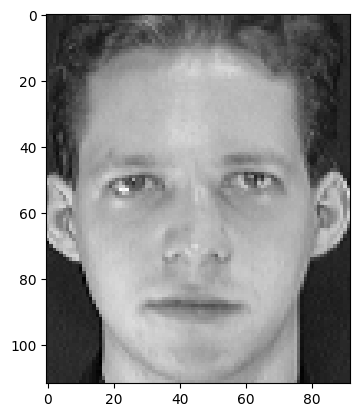

Reconstruction errors (MSE) for training image:
1 eigenfaces: 11787210.479364855
4 eigenfaces: 7528557.971268984
15 eigenfaces: 5320171.437609371
150 eigenfaces: 858899.6269295528
199 eigenfaces: 363420.6130583912
280 eigenfaces: 10.183161109232293


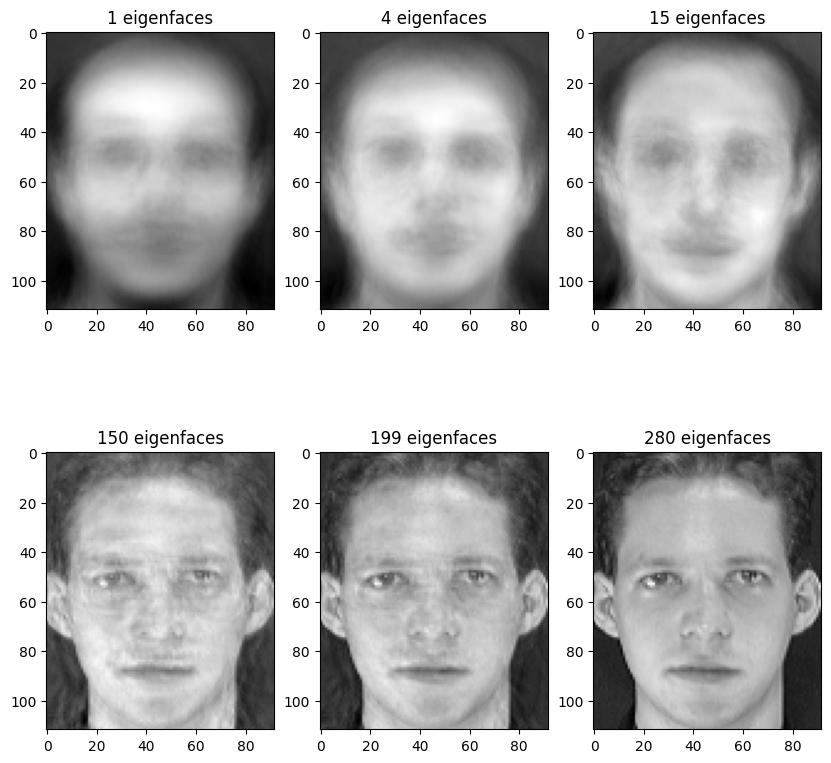

In [ ]:
########################################
# Projection and Reconstruction
########################################

train_img = np.array(Image.open(os.path.join(TRAINING, "s1", "1.pgm")))
train_image_mean_centered = train_img.reshape(shape[0]*shape[1]) - mean
plt.imshow(train_img, cmap='gray')
plt.show()

_, axs = plt.subplots(2, 3, figsize=(10, 10))
axs = axs.flatten()
counts = [1, 4, 15, 150, 199, 280]
print("Reconstruction errors (MSE) for training image:")
for i, ax in enumerate(axs):
    E = eigenfaces[:counts[i]].dot(train_image_mean_centered)
    reconstruction = eigenfaces[:counts[i]].T.dot(E) + mean
    diff = (train_image_mean_centered + mean) - reconstruction
    error = np.dot(diff, diff)
    print(f"{counts[i]} eigenfaces: {error}")
    ax.set_title(f"{counts[i]} eigenfaces")
    ax.imshow(reconstruction.reshape(shape[0], shape[1]), cmap='gray')
plt.show()

In [10]:
########################################
# Lower-dimensional representations
########################################

testE = []    
test_labels = []

projection_dim = 279

# test embeddings
for folder, img_list in test_images.items():
    for im in img_list:
        test_labels.append(int(folder.replace("s", "")))
        img_mean_centered = im.reshape(shape[0] * shape[1]) - mean
        testE.append(eigenfaces[:projection_dim].dot(img_mean_centered))

# training embeddings
trainE = [] 
for im in images:
    img_mean_centered = im.reshape(shape[0] * shape[1]) - mean
    trainE.append(eigenfaces[:projection_dim].dot(img_mean_centered))

In [11]:
########################################
# Prediction functions
########################################

def predictSingle(test_embedding, q=25):
    """
    Given a test image embedding and the number of dimensions (q),
    find the closest training image (using Euclidean distance)
    and return its label.
    """
    smallest_value = None
    predicted_label = None
    # Use first q dimensions of the embedding
    E = test_embedding[:q]
    for i, train_embedding in enumerate(trainE):
        E_compare = train_embedding[:q]
        diff = E - E_compare
        eps = np.linalg.norm(diff)
        if (smallest_value is None) or (eps < smallest_value):
            smallest_value = eps
            predicted_label = labels[i]
    return predicted_label

def predict(q=25):
    """
    Predict labels for all test images using q eigenfaces.
    Returns:
        y_true: list of true labels
        y_pred: list of predicted labels
    """
    y_true = []
    y_pred = []
    for i, emb in enumerate(testE):
        true_label = test_labels[i]
        pred = predictSingle(emb, q)
        y_true.append(true_label)
        y_pred.append(pred)
    return y_true, y_pred

In [ ]:
##############
# Evaluate
##############

q = 25
y_true, y_pred = predict(q=q)
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\nClassification Accuracy (using {q} eigenfaces): {accuracy * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_true, y_pred))


Classification Accuracy (using 25 eigenfaces): 96.67%

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.75      1.00      0.86         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
  

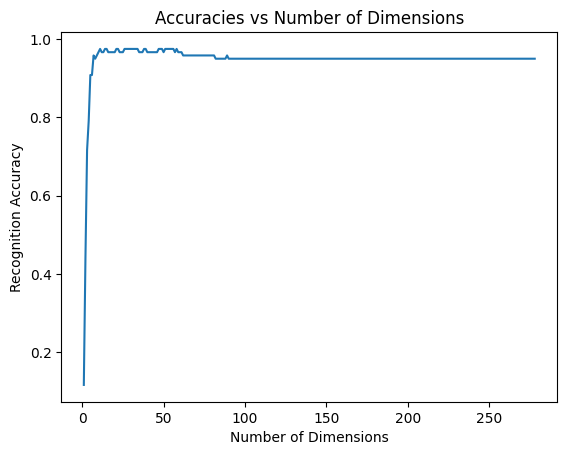

In [ ]:
########################################
# Plot accuracy vs. number of dimensions
########################################

accs = []
dims_range = range(1, projection_dim)
for q in dims_range:
    _, preds = predict(q=q)
    accs.append(np.mean(np.array(test_labels) == np.array(preds)))
plt.plot(dims_range, accs)
plt.title("Accuracies vs Number of Dimensions")
plt.xlabel("Number of Dimensions")
plt.ylabel("Recognition Accuracy")
plt.show()

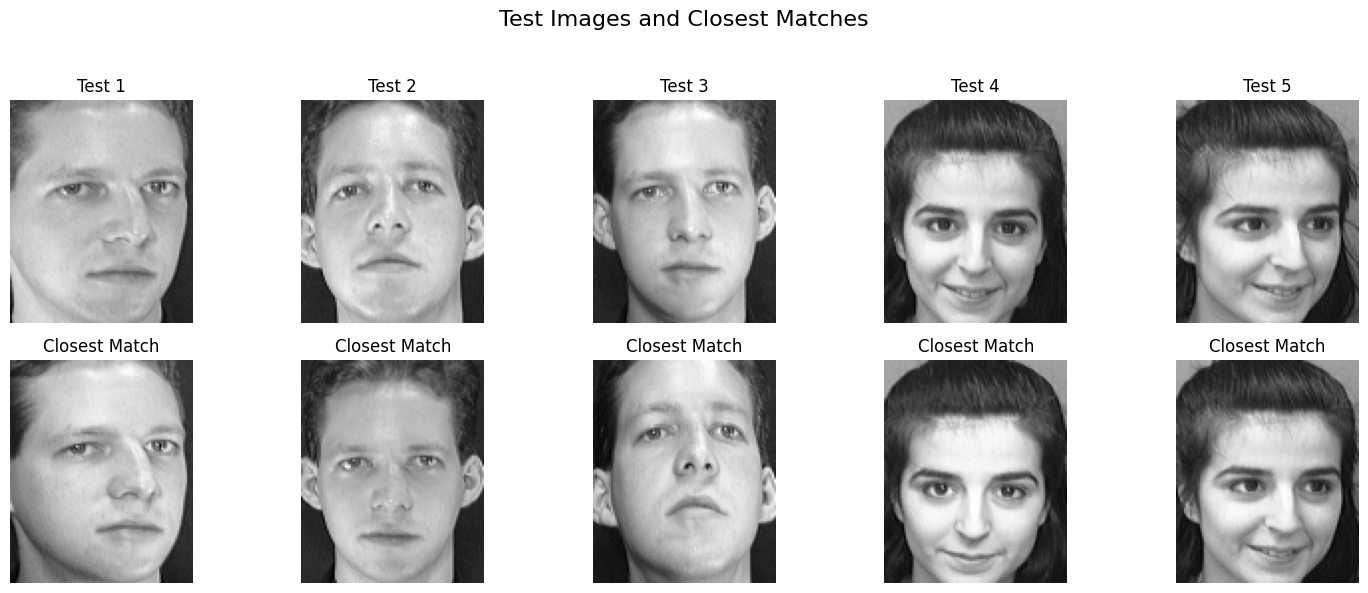

In [ ]:
########################################
# (Optional) Display Closest Matches
########################################

def display_closest_matches(testE, trainE, test_img_paths, train_img_paths, q=25):
    """
    Displays test images (top row) and their closest training matches (bottom row).
    """
    num_samples = 5 
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle("Test Images and Closest Matches", fontsize=16)

    for i in range(num_samples):
        E_test = testE[i][:q]
        closest_index = None
        smallest_distance = float("inf")
        for j, E_train in enumerate(trainE):
            diff = E_test - E_train[:q]
            distance = np.linalg.norm(diff)
            if distance < smallest_distance:
                smallest_distance = distance
                closest_index = j

        # test image
        test_img = np.array(Image.open(test_img_paths[i]))
        axes[0, i].imshow(test_img, cmap="gray")
        axes[0, i].set_title(f"Test {i + 1}")
        axes[0, i].axis("off")

        # closest train image
        train_img = np.array(Image.open(train_img_paths[closest_index]))
        axes[1, i].imshow(train_img, cmap="gray")
        axes[1, i].set_title("Closest Match")
        axes[1, i].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Build lists of image paths for display
test_img_paths = []
for folder in os.listdir(TESTING):
    folder_path = os.path.join(TESTING, folder)
    for img_file in os.listdir(folder_path):
        test_img_paths.append(os.path.join(folder_path, img_file))

train_img_paths = []
for folder in os.listdir(TRAINING):
    folder_path = os.path.join(TRAINING, folder)
    for img_file in os.listdir(folder_path):
        train_img_paths.append(os.path.join(folder_path, img_file))

display_closest_matches(testE, trainE, test_img_paths, train_img_paths, q=25)

In [ ]:
#######################
# Incremental PCA
#######################

n_components = 25 
ipca = IncrementalPCA(n_components=n_components)

def flatten_images(images_list):
    """Flatten a list of images."""
    return np.array([img.reshape(-1) for img in images_list])

# Training Incremental PCA on the training set
X_train_flat = flatten_images(images)
ipca.fit(X_train_flat)
transformed_features = ipca.transform(X_train_flat)

print(f"Initial Explained Variance for {ipca.n_components} components: {np.cumsum(ipca.explained_variance_ratio_)[-1] * 100:.2f}%")
print(f"Initial Classification Accuracy: {accuracy * 100:.2f}%")
print(f"Shape of X_train_flat: {X_train_flat.shape}")
print(f"Shape of transformed_features: {transformed_features.shape}")

# functions for adding and removing faces

def add_face(ipca, new_face_flat, X_train_flat):
    new_face_flat = new_face_flat.reshape(1, -1)
    ipca.partial_fit(new_face_flat)
    X_train_flat_updated = np.vstack([X_train_flat, new_face_flat])
    updated_transformed_features = ipca.transform(X_train_flat_updated)
    return ipca, X_train_flat_updated, updated_transformed_features

def remove_face(ipca, face_index, X_train_flat):
    X_train_flat_updated = np.delete(X_train_flat, face_index, axis=0)
    ipca = IncrementalPCA(n_components=n_components)
    ipca.fit(X_train_flat_updated)
    transformed_features = ipca.transform(X_train_flat_updated)
    return ipca, X_train_flat_updated, transformed_features

new_face_flat = np.random.rand(X_train_flat.shape[1])
ipca, X_train_flat, transformed_features = add_face(ipca, new_face_flat, X_train_flat)

print(f"Explained Variance After Adding New Face: {np.cumsum(ipca.explained_variance_ratio_)[-1] * 100:.2f}%")
print(f"Updated Classification Accuracy After Adding New Face: {predict(q=25)[0]}")  # Note: classification accuracy can be re-computed if desired.
print(f"Shape of X_train_flat after adding new face: {X_train_flat.shape}")
print(f"Shape of transformed_features after adding new face: {transformed_features.shape}")

# Remove a Face (e.g., face with index 5)
face_index_to_remove = 5 
ipca, X_train_flat, transformed_features = remove_face(ipca, face_index_to_remove, X_train_flat)

print(f"Explained Variance After Removing a Face: {np.cumsum(ipca.explained_variance_ratio_)[-1] * 100:.2f}%")
print(f"Updated Classification Accuracy After Removing a Face: {predict(q=25)[0]}")
print(f"Shape of X_train_flat after removing a face: {X_train_flat.shape}")
print(f"Shape of transformed_features after removing a face: {transformed_features.shape}")


Initial Explained Variance for 25 components: 74.04%
Initial Classification Accuracy: 96.67%
Shape of X_train_flat: (280, 10304)
Shape of transformed_features: (280, 25)
Explained Variance After Adding New Face: 74.71%
Updated Classification Accuracy After Adding New Face: [1, 1, 1, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 19, 2, 2, 2, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29, 3, 3, 3, 30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 4, 4, 4, 40, 40, 40, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9]
Shape of X_train_flat after adding new face: (281, 10304)
Shape of transformed_features after adding new face: (281, 25)
Explained Variance After Removing a Face: 74.72%
Updated Classification Accuracy After Removing a Face: [1, 1, 1, 10, 10, 10, 11, 11, 11, 12, 12, 12, 1

In [20]:
import tkinter as tk
from tkinter import ttk, messagebox, simpledialog
import cv2
import numpy as np
from PIL import Image, ImageTk
from sklearn.decomposition import IncrementalPCA
import os

# ---------------------------
# Global Variables and Settings
# ---------------------------
training_data = {}
FACE_WIDTH = 92
FACE_HEIGHT = 112
NUM_IMAGES_PER_PERSON = 7

TRAINING_DIR = "dataset_at&t/Training"
TESTING_DIR = "dataset_at&t/Testing"

n_components = 25
ipca = None
mean_vector = None
eigenfaces = None
training_embeddings = None

# prevents garbage collection
photo_refs = []

# ---------------------------
# Core Utility Functions
# ---------------------------
def load_initial_training_data():
    """
    Load face images from the training directory into training_data.
    """
    if not os.path.exists(TRAINING_DIR):
        messagebox.showerror("Error", f"Training directory '{TRAINING_DIR}' not found!")
        return

    for folder in os.listdir(TRAINING_DIR):
        folder_path = os.path.join(TRAINING_DIR, folder)
        if os.path.isdir(folder_path):
            if folder not in training_data:
                training_data[folder] = []
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                try:
                    img = Image.open(img_path).convert("L")
                    img = img.resize((FACE_WIDTH, FACE_HEIGHT))
                    training_data[folder].append(np.array(img))
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    update_ipca_model()

def flatten_images_from_training_data():
    """
    Flatten all images from training_data into a 2D numpy array.
    Returns the array and a list of corresponding labels.
    """
    images = []
    labels = []
    for label, img_list in training_data.items():
        for img in img_list:
            images.append(img.flatten())
            labels.append(label)
    if images:
        return np.array(images), labels
    else:
        return None, None

def update_ipca_model():
    """
    Recompute the Incremental PCA model using all training images.
    """
    global ipca, mean_vector, eigenfaces, training_embeddings
    X, _ = flatten_images_from_training_data()
    if X is None:
        messagebox.showwarning("No Data", "No training images available to update the model.")
        return
    mean_vector = np.mean(X, axis=0)
    X_centered = X - mean_vector
    ipca = IncrementalPCA(n_components=n_components)
    ipca.fit(X_centered)
    eigenfaces = ipca.components_
    training_embeddings = ipca.transform(X_centered)
    print("IPCA model updated with {} components.".format(n_components))

def predict_label_for_image(face_img):
    """
    Given a face image (grayscale numpy array), predict its label using the PCA model.
    """
    if ipca is None or training_embeddings is None:
        messagebox.showwarning("Model Not Ready", "Please add some faces before testing recognition.")
        return None

    face_vector = face_img.flatten() - mean_vector
    test_embedding = ipca.transform(face_vector.reshape(1, -1))[0]
    distances = np.linalg.norm(training_embeddings - test_embedding, axis=1)
    if distances.size == 0:
        return None
    best_index = np.argmin(distances)
    _, labels = flatten_images_from_training_data()
    return labels[best_index]

def evaluate_test_set():
    """
    Evaluate the recognition accuracy on the test dataset.
    """
    if not os.path.exists(TESTING_DIR):
        messagebox.showerror("Error", f"Testing directory '{TESTING_DIR}' not found!")
        return

    test_images = []
    test_labels = []
    for folder in os.listdir(TESTING_DIR):
        folder_path = os.path.join(TESTING_DIR, folder)
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                try:
                    img = Image.open(img_path).convert("L")
                    img = img.resize((FACE_WIDTH, FACE_HEIGHT))
                    test_images.append(np.array(img))
                    test_labels.append(folder)
                except Exception as e:
                    print(f"Error loading test image {img_path}: {e}")
    if not test_images:
        messagebox.showwarning("No Test Data", "No test images found in the test directory.")
        return

    correct = 0
    for i, img in enumerate(test_images):
        predicted = predict_label_for_image(img)
        if predicted == test_labels[i]:
            correct += 1
    accuracy = correct / len(test_images)
    messagebox.showinfo("Evaluation Result", f"Test set accuracy: {accuracy*100:.2f}%")

# ---------------------------
# GUI Action Functions
# ---------------------------
def add_new_face():
    """
    Capture images from the webcam for a new face and update the PCA model.
    """
    label = simpledialog.askstring("Add Face", "Enter a label for the new face:")
    if label is None or label.strip() == "":
        return

    if label not in training_data:
        training_data[label] = []

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        messagebox.showerror("Webcam Error", "Cannot access the webcam.")
        return

    messagebox.showinfo("Instructions", f"Prepare to capture {NUM_IMAGES_PER_PERSON} images for '{label}'.\nPress 'c' to capture; 'q' to cancel.")
    count = 0
    while count < NUM_IMAGES_PER_PERSON:
        ret, frame = cap.read()
        if not ret:
            messagebox.showerror("Capture Error", "Failed to capture image from webcam.")
            break

        cv2.putText(frame, f"Image {count+1}/{NUM_IMAGES_PER_PERSON} (press 'c')", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        cv2.imshow("Add New Face", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('c'):
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            face = cv2.resize(gray, (FACE_WIDTH, FACE_HEIGHT))
            training_data[label].append(face)
            count += 1
            print(f"Captured image {count} for label '{label}'.")
        elif key == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    if count == NUM_IMAGES_PER_PERSON:
        messagebox.showinfo("Success", f"Successfully added {NUM_IMAGES_PER_PERSON} images for '{label}'.")
        update_ipca_model()
        refresh_label_list()
    else:
        messagebox.showwarning("Incomplete", f"Only {count} images were captured for '{label}'.")

def remove_face():
    """
    Remove all data for a given face label.
    """
    label = simpledialog.askstring("Remove Face", "Enter the label to remove:")
    if label is None or label.strip() == "":
        return

    if label in training_data:
        if messagebox.askyesno("Confirm Removal", f"Are you sure you want to remove all data for '{label}'?"):
            del training_data[label]
            update_ipca_model()
            refresh_label_list()
            messagebox.showinfo("Removed", f"Data for '{label}' has been removed.")
    else:
        messagebox.showwarning("Not Found", f"No face data found for '{label}'.")

def test_recognition():
    """
    Capture a test image from the webcam and display the recognition result.
    """
    if ipca is None:
        messagebox.showwarning("Model Not Ready", "Please add some faces before testing recognition.")
        return

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        messagebox.showerror("Webcam Error", "Cannot access the webcam.")
        return

    messagebox.showinfo("Test Recognition", "Press 'c' to capture a test image; 'q' to cancel.")
    captured = False
    while True:
        ret, frame = cap.read()
        if not ret:
            messagebox.showerror("Capture Error", "Failed to capture image from webcam.")
            break

        cv2.imshow("Test Recognition", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('c'):
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            test_img = cv2.resize(gray, (FACE_WIDTH, FACE_HEIGHT))
            captured = True
            break
        elif key == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    if captured:
        predicted = predict_label_for_image(test_img)
        if predicted is not None:
            truth = simpledialog.askstring("Ground Truth", "Enter the correct label (if known):")
            if truth and truth.strip() != "":
                result_str = "Correct!" if predicted == truth else "Incorrect!"
                messagebox.showinfo("Test Result", f"Predicted: {predicted}\nActual: {truth}\n{result_str}")
            else:
                messagebox.showinfo("Test Result", f"Predicted label: {predicted}")
        else:
            messagebox.showwarning("Result", "Could not predict a label.")
    else:
        messagebox.showwarning("Cancelled", "Test recognition cancelled.")

# ---------------------------
# GUI Helper Functions
# ---------------------------
def refresh_label_list():
    """
    Refresh the listbox displaying available face labels.
    """
    label_listbox.delete(0, tk.END)
    for lbl in sorted(training_data.keys()):
        label_listbox.insert(tk.END, lbl)

def on_label_select(event):
    """
    When a label is selected, display its images in the right pane.
    """
    # Clear previous images
    for widget in image_frame.winfo_children():
        widget.destroy()
    global photo_refs
    photo_refs = []

    selection = label_listbox.curselection()
    if not selection:
        return
    selected_label = label_listbox.get(selection[0])
    if selected_label in training_data:
        title = ttk.Label(image_frame, text=f"Images for {selected_label}", font=("Helvetica", 14, "bold"))
        title.pack(pady=5)
        thumbs_frame = ttk.Frame(image_frame)
        thumbs_frame.pack(fill="both", expand=True)
        cols = 4
        row = 0
        col = 0
        for img in training_data[selected_label]:
            pil_img = Image.fromarray(img)
            photo = ImageTk.PhotoImage(pil_img)
            photo_refs.append(photo)  # Prevent garbage collection
            lbl = ttk.Label(thumbs_frame, image=photo)
            lbl.grid(row=row, column=col, padx=5, pady=5)
            col += 1
            if col >= cols:
                col = 0
                row += 1

# ---------------------------
# Build the GUI using Notebook (Tabs)
# ---------------------------
root = tk.Tk()
root.title("Face Recognition Management System")
root.geometry("950x650")

# ---------------------------
# Styling and Color Scheme
# ---------------------------
# Define a color palette
BG_COLOR = "#2E4053"         # Dark blue-gray background
FG_COLOR = "#ECF0F1"         # Light gray for text
BTN_BG = "#1ABC9C"          # Turquoise buttons
BTN_FG = "#FFFFFF"          # White text on buttons
HDR_COLOR = "#F39C12"       # Orange header color

# Set the root background color
root.configure(bg=BG_COLOR)

# Use a modern theme for ttk and adjust styles for a new color scheme.
style = ttk.Style(root)
style.theme_use("clam")

# Overall frame style
style.configure("TFrame", background=BG_COLOR)

# Label style
style.configure("TLabel", background=BG_COLOR, foreground=FG_COLOR, font=("Helvetica", 12))
style.configure("Header.TLabel", background=BG_COLOR, foreground=HDR_COLOR, font=("Helvetica", 16, "bold"))

# Button style
style.configure("TButton", background=BTN_BG, foreground=BTN_FG, font=("Helvetica", 12), padding=8)
style.map("TButton",
          background=[("active", BTN_BG)],
          foreground=[("active", BTN_FG)])

# Listbox style (for non-ttk widget, set manually later)
listbox_bg = "#34495E"       # Darker blue-gray for listbox background
listbox_fg = FG_COLOR

# ---------------------------
# Create a Notebook for two main tabs
# ---------------------------
notebook = ttk.Notebook(root)
notebook.pack(fill="both", expand=True)

# ----- Tab 1: Manage Faces -----
tab_manage = ttk.Frame(notebook)
notebook.add(tab_manage, text="Manage Faces")

# Left Pane (Labels and Buttons)
left_pane = ttk.Frame(tab_manage, width=300)
left_pane.pack(side="left", fill="y", padx=10, pady=10)

lbl_header = ttk.Label(left_pane, text="Registered Faces", style="Header.TLabel")
lbl_header.pack(pady=5)

list_container = ttk.Frame(left_pane)
list_container.pack(fill="both", expand=True)

scrollbar = ttk.Scrollbar(list_container, orient="vertical")
scrollbar.pack(side="right", fill="y")

# Create a regular Listbox and set its background and foreground colors.
label_listbox = tk.Listbox(list_container, font=("Helvetica", 12), yscrollcommand=scrollbar.set,
                           height=15, bg=listbox_bg, fg=listbox_fg, selectbackground=BTN_BG)
label_listbox.pack(side="left", fill="both", expand=True)
scrollbar.config(command=label_listbox.yview)

label_listbox.bind("<<ListboxSelect>>", on_label_select)

# Buttons for managing faces
btn_frame = ttk.Frame(left_pane)
btn_frame.pack(pady=10)
btn_add = ttk.Button(btn_frame, text="Add Face", command=add_new_face)
btn_add.grid(row=0, column=0, padx=5, pady=5)
btn_remove = ttk.Button(btn_frame, text="Remove Face", command=remove_face)
btn_remove.grid(row=0, column=1, padx=5, pady=5)
btn_refresh = ttk.Button(left_pane, text="Refresh List", command=refresh_label_list)
btn_refresh.pack(pady=5)
btn_exit = ttk.Button(left_pane, text="Exit", command=root.quit)
btn_exit.pack(pady=5)

# Right Pane 
image_frame = ttk.Frame(tab_manage, relief="sunken")
image_frame.pack(side="right", fill="both", expand=True, padx=10, pady=10)

# ----- Tab 2: Test & Evaluate -----
tab_test = ttk.Frame(notebook)
notebook.add(tab_test, text="Test & Evaluate")

test_frame = ttk.Frame(tab_test)
test_frame.pack(fill="both", expand=True, padx=20, pady=20)

test_header = ttk.Label(test_frame, text="Face Recognition Test & Evaluation", style="Header.TLabel")
test_header.pack(pady=10)

btn_test_recog = ttk.Button(test_frame, text="Test Recognition", command=test_recognition)
btn_test_recog.pack(pady=10)
btn_eval_set = ttk.Button(test_frame, text="Evaluate Test Set", command=evaluate_test_set)
btn_eval_set.pack(pady=10)

# ---------------------------
# Initialization
# ---------------------------
load_initial_training_data()
refresh_label_list()

root.mainloop()


IPCA model updated with 25 components.
Captured image 1 for label 'samad'.
Captured image 2 for label 'samad'.
Captured image 3 for label 'samad'.
Captured image 4 for label 'samad'.
Captured image 5 for label 'samad'.
Captured image 6 for label 'samad'.
Captured image 7 for label 'samad'.
IPCA model updated with 25 components.
